## PINNs applied to simplified Black-Scholes model

Given the *simplified* Black-Scholes model : 
for $(x, t) \in [0, 1]^2$, we have
$$
\partial_t u + x\partial_x u + \frac{x^2}{2} \partial^2_{x^2} u - u = 0
$$
with initial condition: $u(x, 0) = e^x - 1$

Here, we demonstrate how to implement PINNs to solve the Black-Scholes model 


In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import numpy as np

In [2]:
"""
In our case: #inputs = 2 (x,t)
and #outputs = 1

"""

class PINN(nn.Module):
    def __init__(self, n_hidden, n_layers):
        """
        n_hidden = nb of hyperparameters in each hidden layers 
        n_layers = nb of hidden layers 
        """
        super(PINN, self).__init__()
        self.layers = nn.ModuleList() 
        for l in range(n_layers): 
            if l == 0 : 
                self.layers.append(nn.Linear(2, n_hidden))
                self.layers.append(nn.Sigmoid())
            else:
                self.layers.append(nn.Linear(n_hidden, n_hidden))
                self.layers.append(nn.Sigmoid())
        self.layers.append(nn.Linear(n_hidden, 1))

    def forward(self, x,t):
        inputs = torch.cat([x,t],axis=1) 
        return nn.Sequential(*self.layers)(inputs)

In [3]:
### (2) Model
pinn = PINN(8, 4)
pinn = pinn.to(device) # to GPU if available
mse_cost_function = torch.nn.MSELoss() # Mean squared error
optimizer = torch.optim.Adam(pinn.parameters())

In [4]:
## PDE as loss function. Thus would use the network which we call as u_theta
def f(x,t, pinn):
    u = pinn(x,t) # the dependent variable u is given by the network based on independent variables x,t
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]
    u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0]
    pde = u_t + x*u_x + (x**2/2)* u_xx - u
    return pde

In [5]:
## Data from Boundary Conditions
# u(x,0)= e^x -1
## BC just gives us datapoints for training

# BC tells us that for any x in range[0,1] and time=0, the value of u is given by 6e^(-3x)
# Take say 500 random numbers of x
x_bc = np.random.uniform(low=0.0, high=1.0, size=(500,1))
t_bc = np.zeros((500,1))
# compute u based on BC
u_bc = np.exp(x_bc) - 1

In [7]:
### (3) Training / Fitting
iterations = 20000
previous_validation_loss = 99999999.0
for epoch in range(iterations):
    
    # Loss based on boundary conditions
    pt_x_bc = Variable(torch.from_numpy(x_bc).float(), requires_grad=False).to(device)
    pt_t_bc = Variable(torch.from_numpy(t_bc).float(), requires_grad=False).to(device)
    pt_u_bc = Variable(torch.from_numpy(u_bc).float(), requires_grad=False).to(device)
    
    net_bc_out = pinn(pt_x_bc, pt_t_bc) # output of u(x,t)
    mse_u = mse_cost_function(net_bc_out, pt_u_bc)
    
    # Loss based on PDE
    x_collocation = np.random.uniform(low=0.0, high=1.0, size=(500,1))
    t_collocation = np.random.uniform(low=0.0, high=1.0, size=(500,1))
    all_zeros = np.zeros((500,1))
    
    
    pt_x_collocation = Variable(torch.from_numpy(x_collocation).float(), requires_grad=True).to(device)
    pt_t_collocation = Variable(torch.from_numpy(t_collocation).float(), requires_grad=True).to(device)
    pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False).to(device)
    
    f_out = f(pt_x_collocation, pt_t_collocation, pinn) # output of f(x,t)
    mse_f = mse_cost_function(f_out, pt_all_zeros)
    
    # Combining the loss functions
    loss = mse_u + mse_f
    
    
    optimizer.zero_grad() # to make the gradients zero
    loss.backward() # This is for computing gradients using backward propagation
    optimizer.step() # This is equivalent to : theta_new = theta_old - alpha * derivative of J w.r.t theta

    if epoch % 500 == 0:
        with torch.autograd.no_grad():
        	print(epoch,"Traning Loss:",loss.data)
    

0 Traning Loss: tensor(0.7658, device='cuda:0')
500 Traning Loss: tensor(0.5181, device='cuda:0')
1000 Traning Loss: tensor(0.0681, device='cuda:0')
1500 Traning Loss: tensor(0.0059, device='cuda:0')
2000 Traning Loss: tensor(0.0030, device='cuda:0')
2500 Traning Loss: tensor(0.0016, device='cuda:0')
3000 Traning Loss: tensor(0.0009, device='cuda:0')
3500 Traning Loss: tensor(0.0007, device='cuda:0')
4000 Traning Loss: tensor(0.0007, device='cuda:0')
4500 Traning Loss: tensor(0.0005, device='cuda:0')
5000 Traning Loss: tensor(0.0005, device='cuda:0')
5500 Traning Loss: tensor(0.0004, device='cuda:0')
6000 Traning Loss: tensor(0.0003, device='cuda:0')
6500 Traning Loss: tensor(0.0002, device='cuda:0')
7000 Traning Loss: tensor(0.0002, device='cuda:0')
7500 Traning Loss: tensor(0.0001, device='cuda:0')
8000 Traning Loss: tensor(0.0001, device='cuda:0')
8500 Traning Loss: tensor(0.0001, device='cuda:0')
9000 Traning Loss: tensor(8.5434e-05, device='cuda:0')
9500 Traning Loss: tensor(7.938

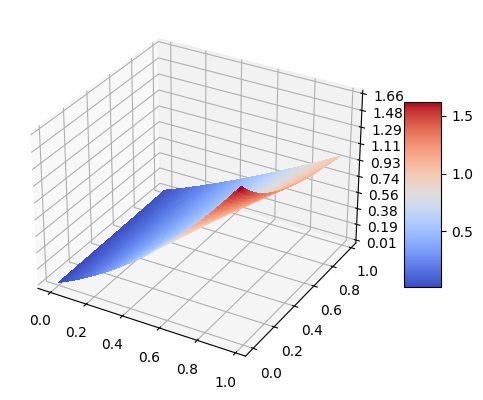

In [8]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

x=np.arange(0,1,0.02)
t=np.arange(0,1,0.02)
ms_x, ms_t = np.meshgrid(x, t)

x = np.ravel(ms_x).reshape(-1,1)
t = np.ravel(ms_t).reshape(-1,1)

pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
pt_t = Variable(torch.from_numpy(t).float(), requires_grad=True).to(device)
pt_u = pinn(pt_x,pt_t)
u=pt_u.data.cpu().numpy()
ms_u = u.reshape(ms_x.shape)

surf = ax.plot_surface(ms_x,ms_t,ms_u, cmap=cm.coolwarm,linewidth=0, antialiased=False)
             
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [9]:
# Save Model
#torch.save(net.state_dict(), "model_PINN.pt")